In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras import Input, Model
from keras import backend as K
from keras.models import  Sequential
from keras.layers import Dense
from keras.utils import *
from sklearn.impute import SimpleImputer

In [2]:
def load_crime_data(crime_dataUCI):
  crime_dataUCI = pd.read_csv(crime_dataUCI, header=None)
  crime_dataUCI = crime_dataUCI.replace('?', np.NAN)
  crime_dataUCI = crime_dataUCI.values

  x = crime_dataUCI[:, 5:127].astype("float")
  y = crime_dataUCI[:, 127:128].astype("float")
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

  fix_nan = SimpleImputer(missing_values=np.NaN, strategy='mean')
  x_train = fix_nan.fit_transform(x_train)
  y_train = fix_nan.fit_transform(y_train)
  x_test = fix_nan.fit_transform(x_test)
  y_test = fix_nan.fit_transform(y_test)

  print(x_train.shape)
  print(x_test.shape)
  print(y_train.shape)
  print(y_test.shape)
  data = x_train, y_train, x_test, y_test
  return data

data_loader = load_crime_data('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data')


(1595, 122)
(399, 122)
(1595, 1)
(399, 1)


In [3]:
def load_crime_data(crime_dataframe):
  crime_df = pd.read_csv(crime_dataframe, delim_whitespace= False, header=None)
  crime_df = crime_df.replace('?', np.NAN)
  crime_df = crime_df.values  
  x_train = crime_df[:1500,5:127].astype("float")
  x_test = crime_df[1500:,5:127].astype("float")
  y_train = crime_df[:1500,127:128].astype("float")
  y_test = crime_df[1500:,127:128].astype("float")
  fix_nan = SimpleImputer(missing_values=np.NaN, strategy='mean')
  x_train = fix_nan.fit_transform(x_train)
  y_train = fix_nan.fit_transform(y_train)
  x_test = fix_nan.fit_transform(x_test)
  y_test = fix_nan.fit_transform(y_test)
  data = (x_train, y_train, x_test, y_test)
  return data

data_loader = load_crime_data('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data')


In [4]:
def crime_model():

  model = tf.keras.Sequential(name="crime_data_model")
  model.add(Dense(64,input_shape=(data_loader[0].shape[1],),activation='relu', name='dense_layer1'))
  model.add(Dense(64,activation='relu',name='dense_layer2'))
  model.add(Dense(1,activation='sigmoid',name='dense_layer3'))

  return model

model = crime_model()


model.summary()

Model: "crime_data_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer1 (Dense)        (None, 64)                7872      
                                                                 
 dense_layer2 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer3 (Dense)        (None, 1)                 65        
                                                                 
Total params: 12,097
Trainable params: 12,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/model-01-{epoch:02d}-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 10,
        min_lr = 1e-5
    ),
]

k = 4
num_val_samples = len(data_loader[0])//k
epochs = 500
scores = []
all_mae_history = []
for i in range(k):
  print("Running fold number ",i+1)
  x_val = data_loader[0][i * num_val_samples: (i+1) * num_val_samples]
  y_val = data_loader[1][i * num_val_samples: (i+1) * num_val_samples]
  train_data = np.concatenate(
        [data_loader[0][:i * num_val_samples],
         data_loader[0][(i+1) * num_val_samples:]],
        axis = 0)
  
  train_labels = np.concatenate(
        [data_loader[1][:i*num_val_samples],
         data_loader[1][(i+1)*num_val_samples:]],
        axis=0)

  model = crime_model()
  model.compile(
    loss="mse",
    optimizer='rmsprop',
	  metrics=['mae']
)
  history = model.fit(train_data, train_labels, epochs= epochs , batch_size=32, verbose=0)
  test_mse_score, test_mae_score = model.evaluate(x_val,y_val)
  print("Test MAE scores :",test_mae_score)
  history_dict = history.history
  mae_history = history.history['mae']
  all_mae_history.append(mae_history)
  val_mse_score, val_mae_score = model.evaluate(x_val, y_val, verbose=0)
  scores.append(val_mae_score)

average_mae_history = [np.mean([a[i] for a in all_mae_history]) for i in range(epochs)]
print("Average Validation MAE history",average_mae_history)

Running fold number  1
12/12 [==============================] - 0s 2ms/step - loss: 0.0274 - mae: 0.1097
Test MAE scores : 0.10973179340362549
Running fold number  2
12/12 [==============================] - 0s 2ms/step - loss: 0.0337 - mae: 0.1268
Test MAE scores : 0.12676183879375458
Running fold number  3
12/12 [==============================] - 0s 2ms/step - loss: 0.0217 - mae: 0.1004
Test MAE scores : 0.10040862113237381
Running fold number  4
12/12 [==============================] - 0s 3ms/step - loss: 0.0225 - mae: 0.1016
Test MAE scores : 0.1016499325633049
Average Validation MAE history [0.14820356667041779, 0.10858486033976078, 0.1009183581918478, 0.09886773489415646, 0.09669263660907745, 0.09665131568908691, 0.09657660499215126, 0.09410140663385391, 0.09449742920696735, 0.09267375059425831, 0.09257464855909348, 0.09224149398505688, 0.09115373715758324, 0.09102728962898254, 0.09127678535878658, 0.09054592251777649, 0.08966048806905746, 0.09022919274866581, 0.08912646397948265,

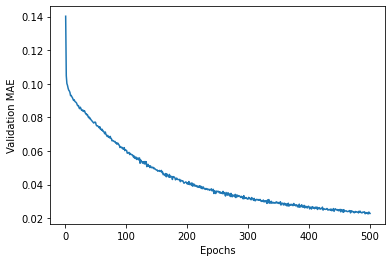

In [ ]:
plt.plot(range(1,len(average_mae_history)+1) , average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


In [ ]:
def new_crime_model():

  model = tf.keras.Sequential(name="crime_data_model_new")
  model.add(Dense(64,input_shape=(data_loader[0].shape[1],),activation='relu', name='dense_layer1'))
  model.add(Dense(32,activation='relu',name='dense_layer2'))
  model.add(Dense(16,activation='relu',name='dense_layer3'))
  model.add(Dense(8,activation='relu',name='dense_layer4'))
  model.add(Dense(4,activation='relu',name='dense_layer5'))
  model.add(Dense(2,activation='relu',name='dense_layer6'))
  model.add(Dense(1,activation='sigmoid',name='dense_layer7'))

  return model

new_model = new_crime_model()


new_model.summary()

Model: "crime_data_model_new"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer1 (Dense)        (None, 64)                7872      
                                                                 
 dense_layer2 (Dense)        (None, 32)                2080      
                                                                 
 dense_layer3 (Dense)        (None, 16)                528       
                                                                 
 dense_layer4 (Dense)        (None, 8)                 136       
                                                                 
 dense_layer5 (Dense)        (None, 4)                 36        
                                                                 
 dense_layer6 (Dense)        (None, 2)                 10        
                                                                 
 dense_layer7 (Dense)        (None, 1)        

In [ ]:
new_model = crime_model()
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/crimeData-mse_{loss:.3f}_mae{mae:.3f}.h5',
        monitor = 'mae',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 10,
        min_lr = 1e-5
    ),
]

rms = tf.keras.optimizers.RMSprop(1e-3)


new_model.compile(
    loss="mse",
    optimizer='rmsprop',
	  metrics=['mae']
)

history1 = new_model.fit(
    data_loader[0], data_loader[1],
    epochs = 50,
    validation_data=(data_loader[2], data_loader[3]),
    callbacks=my_callbacks)

test_mse_score,test_mae_score = new_model.evaluate(data_loader[2],data_loader[3])

Epoch 1/50
47/47 [==============================] - 1s 7ms/step - loss: 0.0361 - mae: 0.1421 - val_loss: 0.0244 - val_mae: 0.1024 - lr: 0.0010
Epoch 2/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0221 - mae: 0.1056 - val_loss: 0.0176 - val_mae: 0.0926 - lr: 0.0010
Epoch 3/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0202 - mae: 0.0988 - val_loss: 0.0220 - val_mae: 0.0989 - lr: 0.0010
Epoch 4/50
47/47 [==============================] - 0s 4ms/step - loss: 0.0204 - mae: 0.0982 - val_loss: 0.0177 - val_mae: 0.0967 - lr: 0.0010
Epoch 5/50
47/47 [==============================] - 0s 4ms/step - loss: 0.0189 - mae: 0.0955 - val_loss: 0.0172 - val_mae: 0.0936 - lr: 0.0010
Epoch 6/50
47/47 [==============================] - 0s 4ms/step - loss: 0.0187 - mae: 0.0943 - val_loss: 0.0174 - val_mae: 0.0940 - lr: 0.0010
Epoch 7/50
47/47 [==============================] - 0s 5ms/step - loss: 0.0190 - mae: 0.0941 - val_loss: 0.0220 - val_mae: 0.1134 - lr: 0.0010

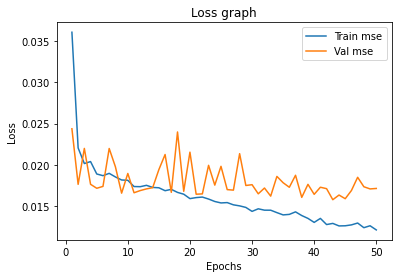

In [ ]:
dict1 = history1.history
loss = dict1['loss']
val_loss = dict1['val_loss']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train mse')
plt.plot(epochs,val_loss,label='Val mse')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()



In [9]:
from keras.models import load_model
model = load_model('./crimeData-36-mse_0.014_mae0.080.h5')

model.compile(loss='mse', optimizer='rmsprop', metrics=['mse'])
score = model.evaluate(data_loader[2], data_loader[3], verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]))

mse: 0.02%
